# (1m)Noise

* **author**: steeve.laquitaine@epfl.ch  
* **purpose**: validation of trace background noise.

### Setup

1. Pre-compute data with mpi on several nodes with `sbatch src/pipes/validation/noise/mpi_npx_full.py`

2. Setup `spikeinterf` venv



In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import multiprocessing
import torch
import copy
import seaborn as sns

# move to PROJECT PATH
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/spikebias/"
os.chdir(PROJ_PATH)

from src.nodes.utils import get_config, get_stats_config, standardize_layers
from src.nodes.validation import noise

# vivo
data_conf_v, param_conf_v = get_config("vivo_marques", "c26").values() 
RAW_PATH_v = data_conf_v["raw"]
PREP_PATH_v = data_conf_v["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_v = data_conf_v["validation"]["noise"]["full"]

# silico best fitted gain and noise
data_conf_s, param_conf_s = get_config("silico_neuropixels", "npx_spont").values()
RAW_PATH_s = data_conf_s["probe_wiring"]["full"]["output"]
PREP_PATH_s = data_conf_s["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_s = data_conf_s["validation"]["noise"]["full"]

# Buccino with best fitted gain for layer 5
data_conf_b, _ = get_config("buccino_2020", "2020").values()
RAW_PATH_b = data_conf_b["probe_wiring"]["full"]["output"]
PREP_PATH_b = data_conf_b["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_b = data_conf_b["validation"]["noise"]["full"]

# neuropixels (evoked biophysical model)
cfg_ne, _ = get_config("silico_neuropixels", "npx_evoked").values()
RAW_PATH_ne = cfg_ne["probe_wiring"]["full"]["output"]
PREP_PATH_ne = cfg_ne["preprocessing"]["full"]["output"]["trace_file_path"]
NOISE_PATH_ne = cfg_ne["validation"]["noise"]["full"]

# parameters
LAYERS = ["L1", "L2/3", "L4", "L5", "L6"]
SFREQ_V = 30000          # sampling frequency
SFREQ_S = 40000        # sampling frequency
SFREQ_B = 32000        # sampling frequency
SFREQ_E = 20000        # sampling frequency

# pipeline parameters
SAVE_FIG = True
SAVE_TEMP_DATA = False
LOAD_TEMP_DATA = True

# save paths
PLOT_DATA_PATH = get_stats_config()["fig2n_data_noise_npx"]

# FIGURE SETTINGS
FIG_SIZE = (1.8, 1.6)
COLOR_VIVO = np.array([153, 153, 153]) / 255
COLOR_SILI = np.array([228, 26, 28]) / 255
COLOR_BUCCI = np.array([55, 126, 184]) / 255
COLOR_NE = [1, 0.49, 0]

# experiment colors
cl = dict()
cl["COLOR_NV"] = [0.6, 0.6, 0.6]
cl["COLOR_NS"] = [0.9, 0.14, 0.15]
cl["COLOR_NB"] = [0.22, 0.5, 0.72] # blue
cl["COLOR_NE"] = [1, 0.49, 0] # orange
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
savefig_cfg = {"transparent":True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame

2024-12-10 15:27:19,986 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:27:20,020 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 15:27:20,022 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:27:20,057 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 15:27:20,058 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:27:20,080 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-12-10 15:27:20,082 - root - utils.py - get_config - INFO - Reading experiment config.
2024-12-10 15:27:20,138 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Specs

In [2]:
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())

available cpus: 72
available gpus: True


### Precompute

* run with mpi on several nodes: `sbatch cluster/validation/noise/mpi_npx_full.sh`

### (1s)Load datasets

* first 10 minutes of recordings


In [2]:
RecV = si.load_extractor(PREP_PATH_v)
RecS = si.load_extractor(PREP_PATH_s)
RecE = si.load_extractor(PREP_PATH_ne)
RecB = si.load_extractor(PREP_PATH_b)

# or load
noise_v = np.load(NOISE_PATH_v, allow_pickle=True)
noise_s = np.load(NOISE_PATH_s, allow_pickle=True)
noise_e = np.load(NOISE_PATH_ne, allow_pickle=True)
noise_b = np.load(NOISE_PATH_b, allow_pickle=True)

/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/binaryrecordingextractor.py:78: UserWarning: `num_chan` is to be deprecated in version 0.100, please use `num_channels` instead
  warnings.warn("`num_chan` is to be deprecated in version 0.100, please use `num_channels` instead")


### Plot noise

#### Compute plot data

In [ ]:
# - get site layers
lyr_v = RecV.get_property("layers")
lyr_s = RecS.get_property("layers")
lyr_e = RecE.get_property("layers")

# build dataset
# vivo
lyr_v = standardize_layers(lyr_v)
in_ctx = np.isin(lyr_v, LAYERS)
v_data = pd.DataFrame(data=np.array(noise_v[in_ctx]), columns=["noise"])
lyr_v = np.array(lyr_v)[in_ctx]
v_data["layer"] = lyr_v
v_data["experiment"] = "npx (Marques-Smith)"
v_data = v_data.sort_values(by=["layer"])

# - group l2 and l3
# spont.
lyr_s = standardize_layers(lyr_s)
in_ctx = np.isin(lyr_s, LAYERS)
s_data = pd.DataFrame(data=np.array(noise_s[in_ctx]), columns=["noise"])
lyr_s = np.array(lyr_s)[in_ctx]
s_data["layer"] = lyr_s
s_data["experiment"] = "Biophy. spont."
s_data = s_data.sort_values(by=["layer"])

# evoked
lyr_e = standardize_layers(lyr_e)
in_ctx = np.isin(lyr_e, LAYERS)
e_data = pd.DataFrame(data=np.array(noise_e[in_ctx]), columns=["noise"])
lyr_e = np.array(lyr_e)[in_ctx]
e_data["layer"] = lyr_e
e_data["experiment"] = "Biophy. evoked"
e_data = e_data.sort_values(by=["layer"])

# buccino
b_data = pd.DataFrame(data=np.array(noise_b), columns=["noise"])
b_data["layer"] = "L5"
b_data["experiment"] = "Synth. (Buccino)"

# concat
plot_data = pd.concat([v_data, s_data, e_data, b_data], ignore_index=True)

# drop sites outside cortex
mask = np.isin(plot_data["layer"], LAYERS)
plot_data = plot_data[mask]
plot_data = plot_data.sort_values(by=["layer"])

# unit-test
layers = ["L1", "L2/3", "L4", "L5", "L6"]
assert v_data["layer"].unique().tolist() == layers, "wrong layers"
assert s_data["layer"].unique().tolist() == layers, "wrong layers"
assert e_data["layer"].unique().tolist() == layers, "wrong layers"

## Load/save temp data

In [2]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_data.to_parquet(PLOT_DATA_PATH)
    print("Saved here:", PLOT_DATA_PATH)
elif LOAD_TEMP_DATA:
    plot_data = pd.read_parquet(PLOT_DATA_PATH)

#### Plot

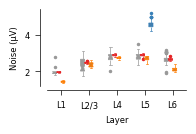

In [7]:
FIG_SIZE = (1.8, 1)

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

ax = sns.boxplot(
    ax=ax,
    data=plot_data,
    x="layer",
    y="noise",
    hue="experiment",
    notch=True,
    hue_order=[
        "npx (Marques-Smith)",
        "Biophy. spont.",
        "Biophy. evoked",
        "Synth. (Buccino)",
    ],
    palette=[cl["COLOR_NV"], cl["COLOR_NS"], cl["COLOR_NE"], cl["COLOR_NB"]],
    width=0.6,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
    },
)

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))

ax.set_ylabel("Noise (\u03bcV)")
ax.set_xlabel("Layer")

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            box.set_edgecolor(cl["COLOR_NV"])
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_NV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_NV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (NS)
            box.set_edgecolor(cl["COLOR_NS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NS"])
                ax.lines[k].set_mfc(cl["COLOR_NS"])
                ax.lines[k].set_mec(cl["COLOR_NS"])
            p += 1
        elif p in [10, 11, 12, 13, 14]:
            box.set_edgecolor(cl["COLOR_NE"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NE"])
                ax.lines[k].set_mfc(cl["COLOR_NE"])
                ax.lines[k].set_mec(cl["COLOR_NE"])
            p += 1
        elif p in [15]:
            box.set_edgecolor(cl["COLOR_NB"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_NB"])
                ax.lines[k].set_mfc(cl["COLOR_NB"])
                ax.lines[k].set_mec(cl["COLOR_NB"])
            p += 1

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/3_noise/fig2N/fig2N_noise_npx.svg",
        bbox_inches="tight",
        **savefig_cfg
    )

## Statistical tests

### Noise changes across layers?

In [8]:
def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.experiment==exp) & (plot_data.layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

# 1. kruskall-wallis
# 2. perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
# 3. medians and ci95
print("\n--------------------MS--------------------\n")
noise.get_kk(plot_data, "npx (Marques-Smith)")
noise.get_posthoc_dunn_holm_sidak(plot_data, "npx (Marques-Smith)")
m_m = get_medians_and_ci95(plot_data, "npx (Marques-Smith)", "noise") 

print("\n--------------------NS--------------------\n")
noise.get_kk(plot_data, "Biophy. spont.")
noise.get_posthoc_dunn_holm_sidak(plot_data, "Biophy. spont.")
m_ns = get_medians_and_ci95(plot_data, "Biophy. spont.", "noise") 

print("\n--------------------E--------------------\n")
noise.get_kk(plot_data, "Biophy. evoked")
noise.get_posthoc_dunn_holm_sidak(plot_data, "Biophy. evoked")
m_e = get_medians_and_ci95(plot_data, "Biophy. evoked", "noise") 


--------------------MS--------------------

H=62.47102557681285, p=8.768468370671957e-13
N_L1 = 10 sites
N_L23 = 42 sites
N_L4 = 34 sites
N_L5 = 42 sites
N_L6 = 98 sites
1.9311 $\pm$ 0.171132, 2.189 $\pm$ 0.116526, 2.8097 $\pm$ 0.086615, 2.8482 $\pm$ 0.070086, 2.6354 $\pm$ 0.038763, 

--------------------NS--------------------

H=178.66644908122998, p=1.441853196249705e-37
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
1.9628 $\pm$ 0.015682, 2.4645 $\pm$ 0.010906, 2.9039 $\pm$ 0.024573, 2.9261 $\pm$ 0.018631, 2.6722 $\pm$ 0.01622, 

--------------------E--------------------

H=171.6940162304055, p=4.527651062676017e-36
N_L1 = 16 sites
N_L23 = 47 sites
N_L4 = 19 sites
N_L5 = 52 sites
N_L6 = 68 sites
1.4329 $\pm$ 0.021381, 2.3516 $\pm$ 0.038406, 2.741 $\pm$ 0.02469, 2.752 $\pm$ 0.033949, 2.1149 $\pm$ 0.024723, 


## Buccino's model

In [12]:
# medians and ci95
get_medians_and_ci95(plot_data, "Synth. (Buccino)", "noise")  

nan $\pm$ nan, nan $\pm$ nan, nan $\pm$ nan, 4.57 $\pm$ 0.016, nan $\pm$ nan, 


/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/envs/spikinterf0_100_5/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Are models and in vivo data the same?

In [3]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["experiment"] == exp) & (df["layer"] == layer)])


def get_noise(df, exp, layer):
    return df[(df["experiment"] == exp) & (df["layer"] == layer)]["noise"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_noise(df, "npx (Marques-Smith)", layer),
        get_noise(df, "Biophy. spont.", layer),
        get_noise(df, "Biophy. evoked", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_NS = {count_sites(df, "Biophy. spont.", layer)} sites""")
    print(f"""N_E = {count_sites(df, "Biophy. evoked", layer)} sites""")
    print(f"""N_M = {count_sites(df, "npx (Marques-Smith)", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "npx (Marques-Smith)", layer),
        get_noise(plot_data, "Biophy. spont.", layer),
        get_noise(plot_data, "Biophy. evoked", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked"]
    df.index = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_noise(plot_data, "npx (Marques-Smith)", layer),
        get_noise(plot_data, "Biophy. spont.", layer),
        get_noise(plot_data, "Biophy. evoked", layer),
        get_noise(plot_data, "Synth. (Buccino)", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked", "Synth. (Buccino)"]
    df.index = ["npx (Marques-Smith)", "Biophy. spont.", "Biophy. evoked", "Synth. (Buccino)"]
    return df

In [4]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_data, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_data, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_data, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_data, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_data, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_data, "L6"))

------LAYER 1:------

H=29.234883720930213, p=4.4846201140856504e-07
N_NS = 16 sites
N_E = 16 sites
N_M = 10 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.645494,0.000148
Biophy. spont.,0.645494,1.000000,0.000001
Biophy. evoked,0.000148,0.000001,1.000000



------LAYER 2/3:------

H=13.327628317983567, p=0.0012762691815353707
N_NS = 47 sites
N_E = 47 sites
N_M = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.002465,0.599581
Biophy. spont.,0.002465,1.000000,0.007381
Biophy. evoked,0.599581,0.007381,1.000000



------LAYER 4:------

H=14.371799765327893, p=0.0007571873215229637
N_NS = 19 sites
N_E = 19 sites
N_M = 34 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000,0.016231,0.112727
Biophy. spont.,0.016231,1.000000,0.000561
Biophy. evoked,0.112727,0.000561,1.000000



------LAYER 5:------

H=44.68570721981405, p=1.979802950953219e-10
N_NS = 52 sites
N_E = 52 sites
N_M = 42 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked,Synth. (Buccino)
npx (Marques-Smith),1.000000e+00,6.170891e-01,6.170891e-01,8.708621e-26
Biophy. spont.,6.170891e-01,1.000000e+00,1.823141e-01,4.083836e-25
Biophy. evoked,6.170891e-01,1.823141e-01,1.000000e+00,1.730862e-37
Synth. (Buccino),8.708621e-26,4.083836e-25,1.730862e-37,1.000000e+00



------LAYER 6:------

H=138.3650527968963, p=9.003482837003048e-31
N_NS = 68 sites
N_E = 68 sites
N_M = 98 sites


,npx (Marques-Smith),Biophy. spont.,Biophy. evoked
npx (Marques-Smith),1.000000e+00,2.890727e-01,2.301698e-24
Biophy. spont.,2.890727e-01,1.000000e+00,6.616927e-25
Biophy. evoked,2.301698e-24,6.616927e-25,1.000000e+00


### H3: Spont. Model and data noises are the same? - Yes

In [25]:
print("\nlayer 1\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L1")

print("\nlayer 2/3\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L2/3")

print("\nlayer 4\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L4")

print("\nlayer 5\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L5")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Synth. (Buccino)", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. spont.", "L6")


layer 1

1 vs. 2, z=66.0, p=0.48379408987835437, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=719.0, p=0.02741632075746762, N_1=42, N_2=47

layer 4

1 vs. 2, z=227.0, p=0.07638507627249845, N_1=34, N_2=19

layer 5

1 vs. 2, z=768.0, p=0.0134009597257908, N_1=42, N_2=52
1 vs. 2, z=0.0, p=8.341564166878022e-59, N_1=42, N_2=384

layer 6

1 vs. 2, z=2933.0, p=0.19122888444827751, N_1=98, N_2=68


### H4: Evoked. Model and data noises are the same - No

In [29]:
print("\nlayer 1\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L1")

print("\nlayer 2/3\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L2/3")

print("\nlayer 4\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L4")

print("\nlayer 5\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L5")

print("\nlayer 6\n")
noise.get_mwu(plot_data, "npx (Marques-Smith)", "Biophy. evoked", "L6")


layer 1

1 vs. 2, z=160.0, p=3.765248078076184e-07, N_1=10, N_2=16

layer 2/3

1 vs. 2, z=766.0, p=0.06981865287214553, N_1=42, N_2=47

layer 4

1 vs. 2, z=326.0, p=0.9633700684150693, N_1=34, N_2=19

layer 5

1 vs. 2, z=945.0, p=0.266600772419991, N_1=42, N_2=52

layer 6

1 vs. 2, z=6438.0, p=2.208498867696382e-33, N_1=98, N_2=68


## Summary statistics

In [6]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

In [18]:
# NEUROPIXELS  ------------------

L1_ns = pc(m_m[0], m_ns[0])
L1_e = pc(m_m[0], m_e[0])

L23_ns = pc(m_m[1], m_ns[1])
L23_e = pc(m_m[1], m_e[1])

L4_ns = pc(m_m[2], m_ns[2])
L4_e = pc(m_m[2], m_e[2])

L5_ns = pc(m_m[3], m_ns[3])
L5_e = pc(m_m[3], m_e[3])

L6_ns = pc(m_m[4], m_ns[4])
L6_e = pc(m_m[4], m_e[4])

# NPX average --------

print("Models median noise are on average ", - np.round(np.median([L1_ns, L1_e, L23_ns, L23_e, L4_ns, L4_e, L5_ns, L5_e, L6_ns, L6_e]),1), "% Marques-Smith data")

# NPX detailed pattern
print("Models median noise are on average ", - np.round(np.median([L1_ns, L1_e, L6_ns, L6_e]),1), "% Marques-Smith data across L1, L6")

print("Models median noise are on average ", - np.round(np.median([L23_ns, L23_ns, L4_ns, L4_e, L5_ns, L5_e]),1), "% Marques-Smith data, across L4 and L5")

Models median noise are on average  1.5 % Marques-Smith data
Models median noise are on average  -9.2 % Marques-Smith data across L1, L6
Models median noise are on average  3.0 % Marques-Smith data, across L4 and L5
